# A simplified emissions factor for each plant - Work in Progress

This notebook is a very earlier work on this analysis competition, and I hope will grow over time. I also would like to use this notebook as an opportunity to showcase some of the remote sensing tools and methods that I have come across over the months that I've been doing this. I still have a lot to learn, but also know that I'm probably more familiar with remote sensing than most people here on Kaggle.

Update 1 (notebook version 4 + 5): Created Sentinel 5 time-series dataframe for a buffered area around each power plant.

First of all, we start by importing a library that is going to become really handy later on to get some information only around the plants

In [1]:
!pip install rasterstats --quiet

In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Geospatial libraries that we will be using for this
import rasterio
import rasterstats
import folium
import geopandas as gpd
from shapely.geometry import Point

## Creating a buffer around the power plants

I'll be using the power plants converted into a GeoJSON (accessible in [this dataset](https://www.kaggle.com/maxlenormand/geolocated-power-plants-geojson) from [this notebook](https://www.kaggle.com/maxlenormand/saving-the-power-plants-csv-to-geojson)).

In [4]:
power_plants_path = '/kaggle/input/geolocated-power-plants-geojson/Geolocated_gppd_120_pr.geojson'
power_plants = gpd.read_file(power_plants_path)

We are only interested in the area around each plant. In order to have only local information for each plant, we can buffer them.

Note here that the unit is in arc degreees, not meters!

In [5]:
buffered_power_plants = power_plants
buffered_power_plants['geometry'] = power_plants.geometry.buffer(0.1)

In [6]:
# Plot on the map
lat=18.200178; lon=-66.664513

def plot_polygons_on_Map(geodataframe,
                       original_latitude = lat,
                       original_longitude = lon,
                       zoom=9):
    plot = folium.Map(location = (original_latitude, original_longitude), zoom_start=zoom)


    geojson = folium.GeoJson(geodataframe,
                            style_function=lambda x: {'Color':'red',
                                                      'fillColor':'yellow' if x['properties']['primary_fuel']=='Solar'  else 'red'})
    popup = folium.Popup(str(geodataframe.primary_fuel))
    popup.add_to(geojson)
    geojson.add_to(plot)

    return(plot)

Yellow filled cirlces are solar plants, the rest are red (Simply to try out some folium libraries so far).

In [7]:
plot_polygons_on_Map(buffered_power_plants)

## Looking into all the Sentinel 5 images at our disposal

In [8]:
# Make a dataframe containing all the S5 raster paths and dates

from datetime import datetime

df_s5 = pd.DataFrame()

files=[]
captured_datetime = []
for dirname, _, filenames in os.walk('/kaggle/input/ds4g-environmental-insights-explorer/eie_data/s5p_no2'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
        captured_datetime.append(datetime.strptime(filename.split('_')[-2],'%Y%m%dT%H%M%S').date())
        
df_s5['S5_path'] = files
df_s5['Captured_datetime'] = captured_datetime

# Sort dataframe by ascending time
df_s5.sort_values('Captured_datetime', inplace=True)
df_s5.reset_index(inplace=True, drop=True)

df_s5.head()

,S5_path,Captured_datetime
0,/kaggle/input/ds4g-environmental-insights-expl...,2018-07-01
1,/kaggle/input/ds4g-environmental-insights-expl...,2018-07-02
2,/kaggle/input/ds4g-environmental-insights-expl...,2018-07-04
3,/kaggle/input/ds4g-environmental-insights-expl...,2018-07-05
4,/kaggle/input/ds4g-environmental-insights-expl...,2018-07-06


In [9]:
print(f"There are {df_s5.shape[0]} Sentinel 5 images from {df_s5['Captured_datetime'][0]} to {df_s5['Captured_datetime'][df_s5.shape[0]-1]}")

There are 387 Sentinel 5 images from 2018-07-01 to 2019-06-29


## Zonal N02 statistics around each power plant

Next step is to get the zonal statistics of the NO2 for each polygon. This is where [rasterstats' zonal statistics come into play](https://pythonhosted.org/rasterstats/manual.html#raster-data-sources)

In [10]:
test_S5_raster_path = df_s5['S5_path'][0]

We can only use 1 band at a time for the zonal statistics, so we need to know which one to use

In [11]:
def return_bands(file_name):
    # Function from the organizers: https://www.kaggle.com/paultimothymooney/explore-image-metadata-s5p-gfs-gldas
    image = rasterio.open(file_name)
    for i in image.indexes:
        desc = image.descriptions[i-1]
        print(f'{i}: {desc}')
        
return_bands(test_S5_raster_path)

1: NO2_column_number_density
2: tropospheric_NO2_column_number_density
3: stratospheric_NO2_column_number_density
4: NO2_slant_column_number_density
5: tropopause_pressure
6: absorbing_aerosol_index
7: cloud_fraction
8: sensor_altitude
9: sensor_azimuth_angle
10: sensor_zenith_angle
11: solar_azimuth_angle
12: solar_zenith_angle


Just as this is a test to develop the method more than anything, I'll use the 1st band, the N02 column number density. This seems to be what is used in the code provided by the organizers, for now this will be good enough

In [12]:
power_plants_stats = rasterstats.zonal_stats(power_plants_path,
                                                 test_S5_raster_path,
                                                 band=1,
                                                 stats=['mean'])

/opt/conda/lib/python3.6/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


We can see what the first few mean N02 around each plant look like:

In [13]:
# Plotting the first few elements
power_plants_stats[:5]

[{'mean': 6.181962817208841e-05},
 {'mean': 5.856942880200222e-05},
 {'mean': 5.531043279916048e-05},
 {'mean': 5.974839586997405e-05},
 {'mean': 5.6355630947451124e-05}]

## Simplified emissions factor

We're going to start by saying our simplified emissions factor is: SEF = [N02 measurement] / [Quantity of electricity generated]****

In [14]:
cols_to_keep = ['system:index', 'capacity_mw', 'commissioning_year', 'estimated_generation_gwh', 'primary_fuel',  'geometry']
simplified_emissions_factor_df = buffered_power_plants.copy(deep=True)
simplified_emissions_factor_df = simplified_emissions_factor_df[cols_to_keep]

simplified_emissions_factor_df['mean_N02'] = [x['mean'] for x in power_plants_stats]

In [15]:
simplified_emissions_factor_df['Simpl_Emiss_Factor'] = simplified_emissions_factor_df['mean_N02'] / simplified_emissions_factor_df['estimated_generation_gwh']

Text(0.5, 1.0, 'Simplified Emission Factor for each plant (N02 / Estimated Emsission)')

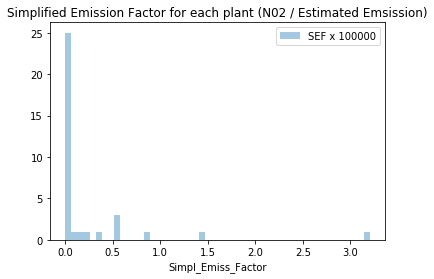

In [16]:
MULTIPLICATION_FACTOR = 100000

plt.figure()
sns.distplot(simplified_emissions_factor_df['Simpl_Emiss_Factor']*MULTIPLICATION_FACTOR,
             kde=False, 
             label=f'SEF x {MULTIPLICATION_FACTOR}')
plt.legend()
plt.title('Simplified Emission Factor for each plant (N02 / Estimated Emsission)')

As many have pointed out, there seems to be a big outlier. I knew this from the get-go, but just wanted to have something working roughly before tackling that problem.

## Getting a N02 time-series for each power plant

Now that we have a time-series of Sentinel 5, and a buffer around each power plant, we can get the N02 readings for each Sentinel 5 image, for each power plant

As a first step, we will only do this over the 1st band, once again.

This next step is going to take a while to compute (~12 minutes). It could probably be optimized, but that will be for later

In [17]:
SUBSET_TO_TEST = df_s5.shape[0]

N02_measurments_df = pd.DataFrame({'index_power_plant':power_plants['system:index']})

for s5_image in tqdm(range(SUBSET_TO_TEST)):
    S5_raster_stats = rasterstats.zonal_stats(power_plants_path,
                                                     df_s5['S5_path'][s5_image],
                                                     band=1,
                                                     stats=['mean'])
    list_of_S5_raster_stats = [plant['mean'] for plant in S5_raster_stats]
    
    N02_measurments_df[df_s5['Captured_datetime'][s5_image]] = list_of_S5_raster_stats

100%|██████████| 387/387 [11:19<00:00,  1.76s/it]


In [18]:
N02_measurments_df.head()

,index_power_plant,2018-07-01,2018-07-02,2018-07-04,2018-07-05,2018-07-06,2018-07-07,2018-07-08,2018-07-09,2018-07-10,...,2019-06-20,2019-06-21,2019-06-22,2019-06-23,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29
0,0000000000000000315a,0.000062,0.000059,0.000061,0.000065,0.000058,NaN,0.000057,NaN,0.000050,...,0.000039,0.000066,0.000065,0.000057,0.000062,0.000053,0.000071,0.000072,0.000060,0.000063
1,000000000000000026e5,0.000059,0.000048,0.000056,0.000057,0.000049,NaN,0.000059,NaN,0.000057,...,0.000059,0.000066,0.000058,0.000061,0.000046,0.000057,0.000066,0.000067,0.000058,0.000054
2,00000000000000002fda,0.000055,0.000053,0.000060,0.000057,0.000055,NaN,0.000050,NaN,0.000054,...,0.000052,0.000063,0.000062,0.000046,0.000045,0.000058,0.000064,0.000063,0.000057,0.000056
3,00000000000000003f76,0.000060,0.000059,0.000074,0.000055,0.000065,NaN,0.000074,NaN,0.000065,...,0.000071,0.000081,0.000069,0.000073,0.000066,0.000046,0.000069,0.000070,0.000064,0.000072
4,00000000000000002def,0.000056,0.000053,0.000056,0.000058,0.000052,NaN,0.000053,NaN,0.000048,...,0.000058,0.000062,0.000057,0.000055,0.000050,0.000055,0.000069,0.000053,0.000058,0.000058


## Investigating time-series of 1 power plant

First of all, we're just going to look at the N02 measurement of a single plant

In [19]:
print(f'There are {N02_measurments_df.iloc[0].isna().sum()} NaNs ({np.round((N02_measurments_df.iloc[0].isna().sum() / N02_measurments_df.shape[1]) * 100, 2)}% of data)')

There are 32 NaNs (9.28% of data)


In [20]:
# Removing NaNs

test_power_plant_time_series = N02_measurments_df.iloc[0].dropna()
test_power_plant_time_series.isna().sum()

0

Text(0.5, 1.0, 'N02 measurement of plant 0000000000000000315a')

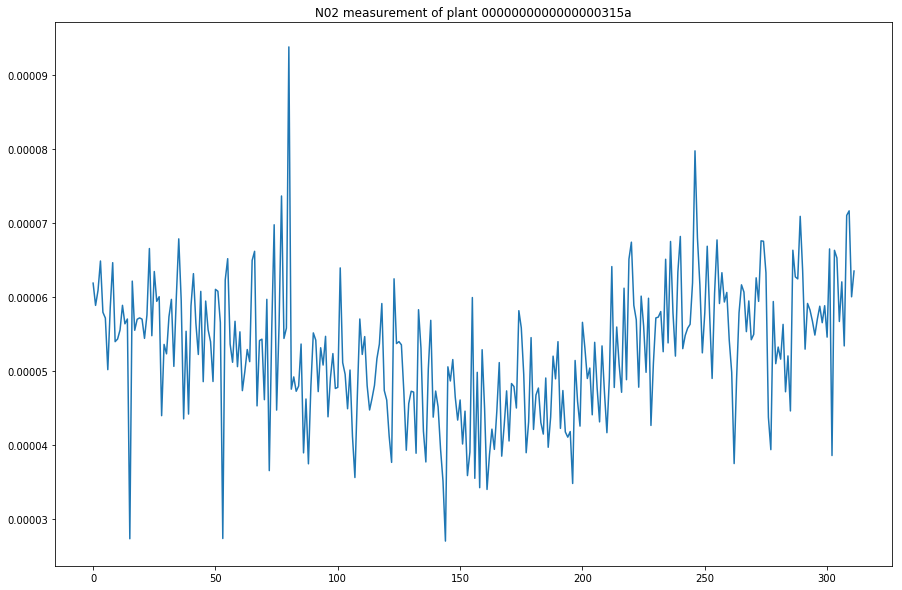

In [21]:
plt.figure(figsize=(15, 10))
plt.plot(list(test_power_plant_time_series[1:]))
plt.title(f'N02 measurement of plant {N02_measurments_df["index_power_plant"][0]}')

## Looking at differences between different kinds of power plants

We'll look if there are any differences for N02 emissions for different types of power plants

In [22]:
# Making a dataframe only keeping the info related to the enegery production

power_plant_type_infos = power_plants[['capacity_mw', 'commissioning_year', 'estimated_generation_gwh', 'primary_fuel']]
power_plant_type_infos.head()

,capacity_mw,commissioning_year,estimated_generation_gwh,primary_fuel
0,15.0,1942.0,685.397712,Hydro
1,1492.0,1975.0,8334.010812,Oil
2,990.0,1962.0,5529.940150,Oil
3,602.0,1960.0,3362.650475,Oil
4,10.0,1915.0,456.931808,Hydro


Different types of power plants and their counts:

In [23]:
np.unique(power_plant_type_infos.primary_fuel, return_counts=True)

(array(['Coal', 'Gas', 'Hydro', 'Oil', 'Solar', 'Wind'], dtype=object),
 array([ 1,  9, 11,  6,  6,  2]))

In [24]:
id_coal = power_plant_type_infos.loc[power_plant_type_infos['primary_fuel']=='Coal'].index.values[0]
id_coal

28

There are 0 NaNs left
There are 0 NaNs left


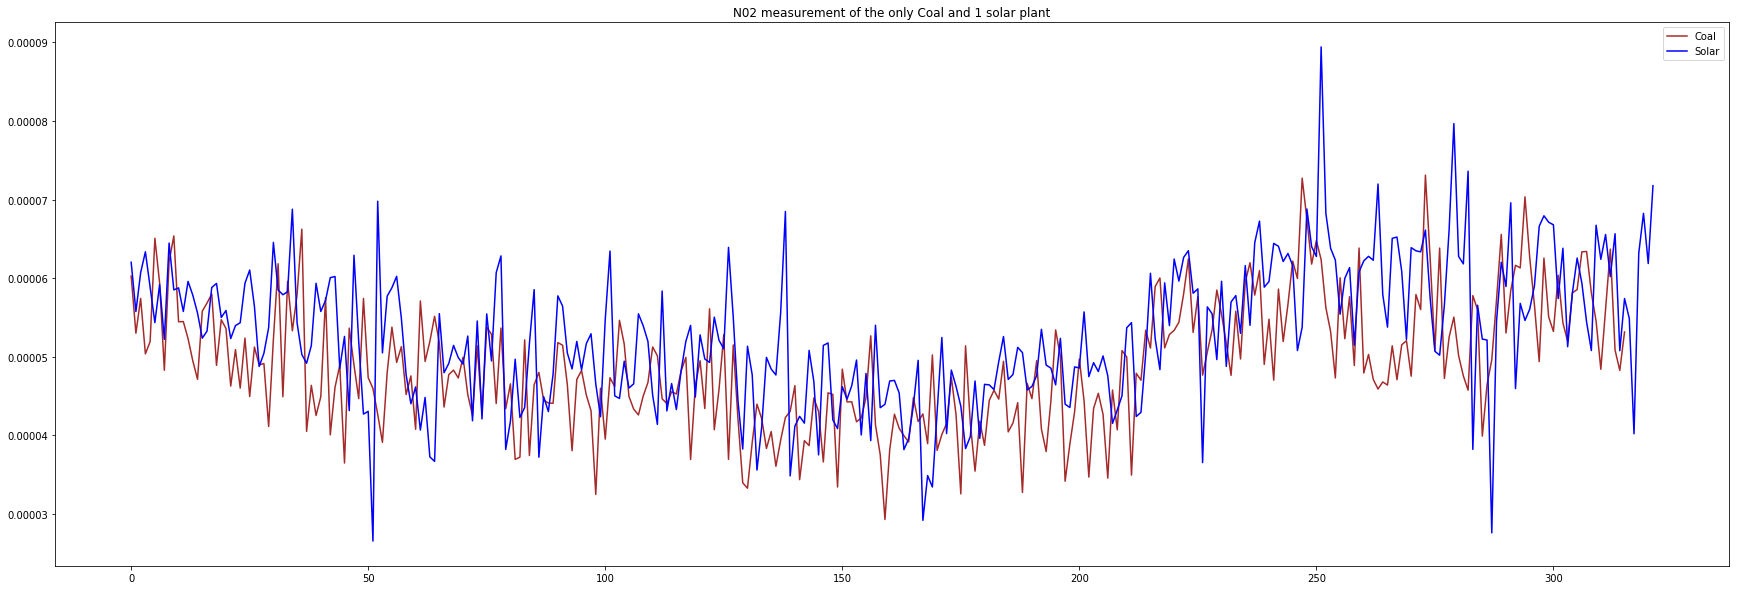

In [25]:
# Looking for coal and solar

# --- Coal ----

# Removing NaNs
id_coal = power_plant_type_infos.loc[power_plant_type_infos['primary_fuel']=='Coal'].index.values[0]
coal_plants_stats = N02_measurments_df.iloc[id_coal].dropna()
print(f'There are {coal_plants_stats.isna().sum()} NaNs left')

# --- Solar ----

# Removing NaNs (only keeping 1 of the solar plants)
id_solar = power_plant_type_infos.loc[power_plant_type_infos['primary_fuel']=='Solar'].index.values[0]
solar_plants_stats = N02_measurments_df.iloc[id_solar].dropna()
print(f'There are {solar_plants_stats.isna().sum()} NaNs left')


plt.figure(figsize=(30, 10))

plt.plot(list(coal_plants_stats[1:]), label='Coal', color='brown')
plt.plot(list(solar_plants_stats[1:]), label='Solar', color='blue')

plt.legend()
plt.title(f'N02 measurement of the only Coal and 1 solar plant')
plt.show()


plants_of_interest = buffered_power_plants.iloc[[id_solar, id_coal]]
plot_polygons_on_Map(geodataframe=plants_of_interest)

## Conclusions (for now) + future work

This is a hyper simple approach, and just a small improvement on what the organizers had created. I just wanted to show how rasterstats could be used in this context to get zonal statistics around each plant.

There are a lot of issues at hand:
- Here I only used 1 image, while we would want to use all the images of a given year.
- I also only used the estimated emissions column, but we have no info on when that is, nor for how long? This is where I think things start getting really tricky.
- For now, there is basically no model, it's just some computing of a very simplified emissions factor. Ideally, we want to be able to know our ground truth, which also seems like it's going to be tricky.
- We need to find how to get the activation rate, or even the effficiency of the plants somehow to get a more accurate model.
- As pointed out in some other topcis / notebooks, Sentinel 5 meaures the N02 over the country, wherever it might come from. So we're going to have to find a way to remove all external sources (like cars, housing, etc.) even if it seems like some of the plants might be further from cities than others.
- There's probably some pre-processing to be done on some of the images. I've never worked on Sentinel 5, but want to look deaper into it.
- Find more info about weather data, impact of temperature, winds, etc. on N02. (maybe when it's colder, there is more demande for electricity (heating) which would be seen in the N02 emissions?).
- A lot of other things!